In [1]:
# sklearn version 0.19.0 or 0.19.1 required
# import sklearn
# sklearn.__version__
# python 3.0 recommended

from __future__ import division, print_function, unicode_literals
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split #from model_selection instead of cross_validation
from sklearn.model_selection import validation_curve #from model_selection instead of learning_curve
from sklearn.model_selection import learning_curve
from sklearn.utils import shuffle

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

certain portion of code was borrowed from "Hands-On Machine Learning with Scikit-Learn and TensorFlow" Book

In [2]:
# To plot pretty figures
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_ID = "classification"
DATASET_ID = "_red-wine_" # for red wine dataset

# Functions
def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, PROJECT_ID + DATASET_ID + fig_id)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)
    
def plot_curve(sizes, data, dots=True, **kwargs):
    mu, std = data.mean(1), data.std(1)
    if dots:
        lines = plt.plot(sizes, mu, 'o-', **kwargs)
    else:
        lines = plt.plot(sizes, mu, '-', **kwargs)
    plt.fill_between(sizes, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.3)
    
def normalize_data(df, columns):
    for column in columns:
        mean_value = df.loc[:,column].mean()
        stdev = np.std(df.loc[:,column].values)
        df.loc[:,column] = (df.loc[:,column] - mean_value) / stdev
    return df

# winequality-red Dateset import (only red wine data)
https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
Saving figure original_histogram


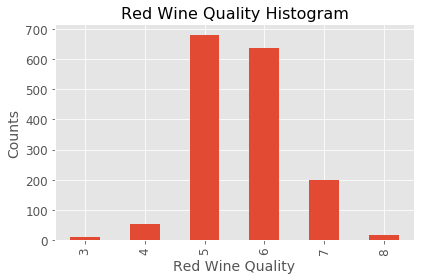

In [3]:
# load csv file
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(url, sep=';') 

column_list = list(df.columns)[0:-1]
print (column_list)

# plot red wine quality counts histogram
df.quality.value_counts().sort_index().plot(kind = 'bar')
plt.xlabel('Red Wine Quality'); plt.ylabel('Counts')
plt.title('Red Wine Quality Histogram', fontsize=16)
save_fig('original_histogram', tight_layout=True)

Saving figure lumped_histogram


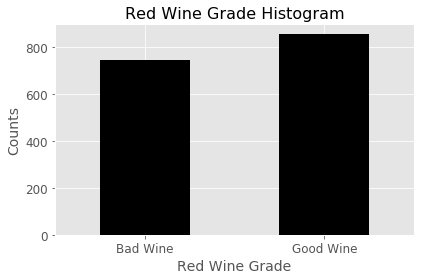

In [4]:
# Since some of the categories don't have enough samples, all categories are lumped into two major categories
# Grade 1: quality equal or better than 6
# Grade 2: all others
df['grade'] = np.array(['Good Wine' if i>=6 else 'Bad Wine' for i in df['quality']])
target = 'grade'

# plot lumped cagegories
df.grade.value_counts().sort_index(ascending=True).plot(kind = 'bar', color=['k', 'r'])
plt.xticks(rotation=0)
plt.xlabel('Red Wine Grade'); plt.ylabel('Counts')
plt.title('Red Wine Grade Histogram', fontsize=16)
save_fig('lumped_histogram', tight_layout=True)

since this binary dataset is well balanced, a simple accuracy calculation could do a good model evaluation job

https://tryolabs.com/blog/2013/03/25/why-accuracy-alone-bad-measure-classification-tasks-and-what-we-can-do-about-it/

In [5]:
X = df[column_list].values
y = df[target].values

# Data normalization is important for ANN
df = normalize_data(df, column_list) 
df.describe().T
X = df[column_list].values

# Data shuffling
X, y = shuffle(X, y, random_state=123)

# Data spliting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)
X_train_size = X_train.shape[0]

In [6]:
df.grade.value_counts(normalize=True)

Good Wine    0.534709
Bad Wine     0.465291
Name: grade, dtype: float64

# DecisionTreeClassifier

Saving figure Decision Tree Complexity Curve


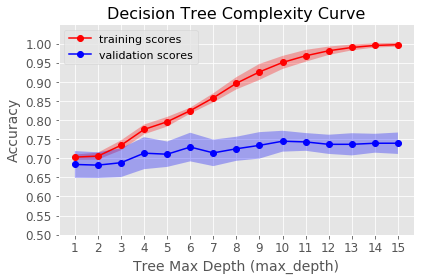

In [7]:
def plot_complexity_curve_dt():
    param_name="max_depth"
    param_range=range(1,16)
    val_train, val_test = validation_curve(DecisionTreeClassifier(random_state=0),
                                           X_train, y_train, 
                                           param_name=param_name, param_range=param_range, cv=10)
    plot_curve(param_range, val_train, label='training scores', color = 'r')
    plot_curve(param_range, val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xticks(param_range)
    plt.xlabel('Tree Max Depth (max_depth)'); plt.ylabel('Accuracy')
    plt.title('Decision Tree Complexity Curve', fontsize=16)
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('Decision Tree Complexity Curve', tight_layout=True)
    
plot_complexity_curve_dt()

based on Decision Tree COmplexity Curve, max_depth = 10 is chosen for following Decision Tree analysis

Saving figure Decision Tree Learning Curve


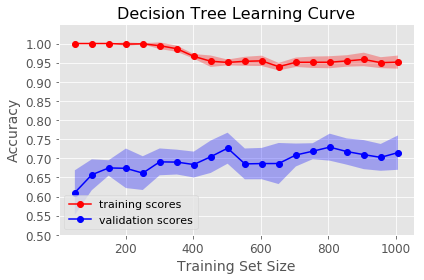

In [8]:
def plot_learning_curve_dt():
    train_sizes = np.linspace(0.05, 1, 20)
    N_train, val_train, val_test = learning_curve(DecisionTreeClassifier(max_depth=10),
                                                  X_train, y_train, train_sizes=train_sizes, cv=10)
    plot_curve(N_train, val_train, label='training scores', color = 'r')
    plot_curve(N_train, val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('Training Set Size'); plt.ylabel('Accuracy')
    plt.title('Decision Tree Learning Curve', fontsize=16)
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('Decision Tree Learning Curve', tight_layout=True)
    
plot_learning_curve_dt()

In [9]:
dt_clf = DecisionTreeClassifier(max_depth = 10, random_state=0)
dt_clf.fit(X_train, y_train)
test_score = dt_clf.score(X_test, y_test)
print ('Decision Tree Model Prediction Accuracy on Test Data: {:.4f}'.format(test_score))

0.73124999999999996

# MLPClassifier

# data normalizing is important for MLPClassifier

In [10]:
# parameters={
# 'learning_rate': ["constant", "invscaling", "adaptive"],
# 'hidden_layer_sizes': [(100,1), (100,2), (100,3)],
# 'alpha': [10.0 ** -np.arange(1, 7)],
# 'activation': ["logistic", "relu", "Tanh"]
# }

# clf = gridSearchCV(estimator=MLPClassifier,param_grid=parameters,n_jobs=-1,verbose=2,cv=10)

In [11]:
sizes = [(10,), (10, 10), (10, 10, 10), (10, 10, 10, 10), (10, 10, 10, 10, 10)]
for i in sizes:
    print (i)

(10,)
(10, 10)
(10, 10, 10)
(10, 10, 10, 10)
(10, 10, 10, 10, 10)


Saving figure MLP Complexity Curve 1 (hidden_layer_sizes)


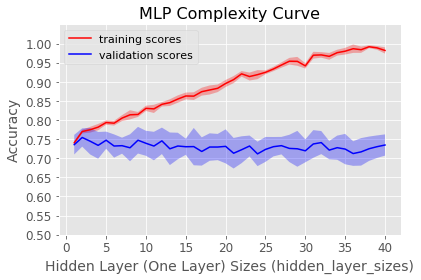

In [12]:
# first complexity curve on hidden layer size with default parameters
def plot_complexity_curve_mlp1():
    param_name="hidden_layer_sizes"
    param_range=range(1,41)
    val_train, val_test = validation_curve(MLPClassifier(solver='lbfgs', random_state=0),
                                           X_train, y_train,
                                           param_name=param_name, param_range=param_range, cv=10)
    plot_curve(param_range, val_train, label='training scores', color = 'r', dots = False)
    plot_curve(param_range, val_test, label='validation scores', color = 'b', dots = False)
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('Hidden Layer (One Layer) Sizes (hidden_layer_sizes)'); plt.ylabel('Accuracy')
    plt.title('MLP Complexity Curve 1 (hidden_layer_sizes)', fontsize=16)
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('MLP Complexity Curve 1 (hidden_layer_sizes)', tight_layout=True)
    
plot_complexity_curve_mlp1()

Saving figure MLP Complexity Curve 3 (hidden_layer numbers)


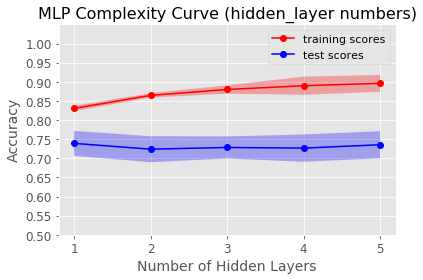

In [13]:
def plot_complexity_curve_mlp2():
    val_train_result = [np.array([])]
    val_train_std = np.array([])
    val_test_result = np.array([])
    val_test_std = np.array([])
    sizes = [(10,), (10, 10), (10, 10, 10), (10, 10, 10, 10), (10, 10, 10, 10, 10)]
    for i in sizes:
        clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes = i, random_state=0)
        results = cross_validate(clf, X_train, y_train, cv=10, return_train_score=True)

        val_train_result = np.append(val_train_result, results['train_score'].mean())
        val_test_result = np.append(val_test_result, results['test_score'].mean())
        val_train_std = np.append(val_train_std, results['train_score'].std())
        val_test_std = np.append(val_test_std, results['test_score'].std())                     
        
    lines1 = plt.plot(range(1,6),val_train_result , 'o-', color = 'r', label='training scores')
    lines2 = plt.plot(range(1,6),val_test_result , 'o-', color = 'b', label='test scores')

    plt.fill_between(range(1,6), val_train_result - val_train_std, val_train_result + val_train_std, edgecolor='none',
                     facecolor=lines1[0].get_color(), alpha=0.3)
    plt.fill_between(range(1,6), val_test_result - val_test_std, val_test_result + val_test_std, edgecolor='none',
                     facecolor=lines2[0].get_color(), alpha=0.3)
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xticks(range(1, 6))
    plt.xlabel('Number of Hidden Layers'); plt.ylabel('Accuracy')
    plt.title('MLP Complexity Curve 2 (hidden_layer numbers)', fontsize=16)    
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('MLP Complexity Curve 2 (hidden_layer numbers)', tight_layout=True)
    
plot_complexity_curve_mlp2()

Saving figure MLP Complexity Curve 3 (max_iter)


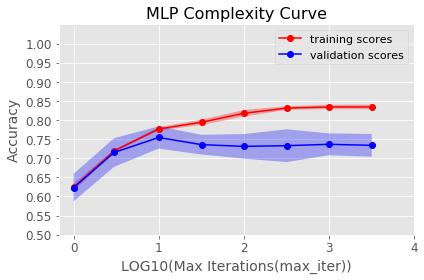

In [14]:
def plot_complexity_curve_mlp3():
    param_name="max_iter"
    param_range=[1, 3, 10, 32, 100, 320, 1000, 3200]
    val_train, val_test = validation_curve(MLPClassifier(solver='lbfgs', hidden_layer_sizes=10, random_state=0),
                                           X_train, y_train,
                                           param_name=param_name, param_range=param_range, cv=10)
    #print (val_train)
    plot_curve(np.log10(param_range), val_train, label='training scores', color = 'r')
    plot_curve(np.log10(param_range), val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xticks(range(0, 5))
    plt.xlabel('LOG10(Max Iterations(max_iter))'); plt.ylabel('Accuracy')
    plt.title('MLP Complexity Curve 3 (max_iter)', fontsize=16)
    plt.legend(fontsize=11)
    #plt.grid()
    save_fig('MLP Complexity Curve 3 (max_iter)', tight_layout=True)
    
plot_complexity_curve_mlp3()

Saving figure MLP Complexity Curve 4 (alpha)


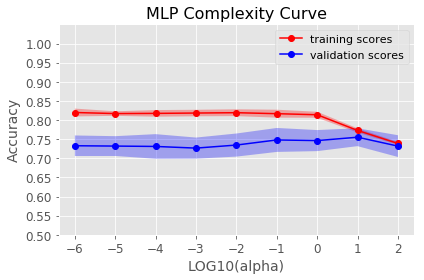

In [15]:
def plot_complexity_curve_mlp4():
    param_name="alpha"
    param_range=[1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 10, 100]
    val_train, val_test = validation_curve(MLPClassifier(solver='lbfgs', hidden_layer_sizes=10, max_iter = 100, random_state=0),
                                           X_train, y_train,
                                           param_name=param_name, param_range=param_range, cv=10)
    #print (val_train)
    plot_curve(np.log10(param_range), val_train, label='training scores', color = 'r')
    plot_curve(np.log10(param_range), val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('LOG10(alpha)'); plt.ylabel('Accuracy')
    plt.title('MLP Complexity Curve 4 (alpha)', fontsize=16)
    plt.legend(fontsize=11)
    #plt.grid()
    save_fig('MLP Complexity Curve 4 (alpha)', tight_layout=True)
    
plot_complexity_curve_mlp4()

Saving figure MLP Complexity Curve 5 (hidden_layer_sizes again)


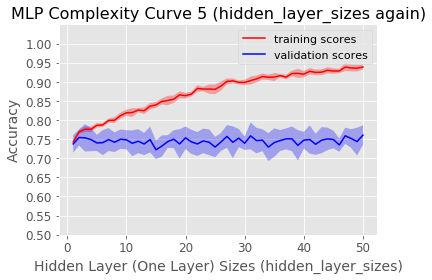

In [35]:
# to double check all parameters
def plot_complexity_curve_mlp5():
    param_name="hidden_layer_sizes"
    param_range=range(1,51)
    val_train, val_test = validation_curve(MLPClassifier(solver='lbfgs', alpha = 1e0, max_iter = 300, random_state=0),
                                           X_train, y_train,
                                           param_name=param_name, param_range=param_range, cv=10)
    plot_curve(param_range, val_train, label='training scores', color = 'r', dots = False)
    plot_curve(param_range, val_test, label='validation scores', color = 'b', dots = False)
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('Hidden Layer (One Layer) Sizes (hidden_layer_sizes)'); plt.ylabel('Accuracy')
    plt.title('MLP Complexity Curve 5 (hidden_layer_sizes again)', fontsize=16)
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('MLP Complexity Curve 5 (hidden_layer_sizes again)', tight_layout=True)

plot_complexity_curve_mlp5()

Saving figure MLP Learning Curve


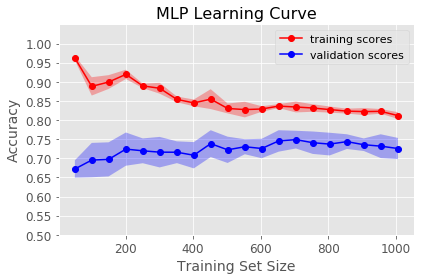

In [36]:
def plot_learning_curve_mlp():
    train_sizes = np.linspace(0.05, 1, 20) 
    # if the train size is too small, training sample may only contain one class
    N_train, val_train, val_test = learning_curve(MLPClassifier(solver='lbfgs', alpha=1e0, 
                        hidden_layer_sizes=10, max_iter = 300, random_state=1),
                                                  X_train, y_train, train_sizes=train_sizes, cv=10)
    plot_curve(N_train, val_train, label='training scores', color = 'r')
    plot_curve(N_train, val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('Training Set Size'); plt.ylabel('Accuracy')
    plt.title('MLP Learning Curve', fontsize=16)
    plt.legend(fontsize=11)
    #plt.grid()
    save_fig('MLP Learning Curve', tight_layout=True)
    
plot_learning_curve_mlp()

In [18]:
# mlp_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, 
#                         hidden_layer_sizes=(10, 2), max_iter = 200,random_state=0)
mlp_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, 
                        hidden_layer_sizes=10, max_iter = 100,random_state=0)
mlp_clf.fit(X_train, y_train)
mlp_clf.score(X_test, y_test)

0.75208333333333333

In [19]:
# mlp_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, 
#                         hidden_layer_sizes=(10, 2), max_iter = 200,random_state=0)
mlp_clf = MLPClassifier(solver='lbfgs', alpha=1e0, 
                        hidden_layer_sizes=10, max_iter = 1000,random_state=0)
mlp_clf.fit(X_train, y_train)
mlp_clf.score(X_test, y_test)

0.7729166666666667

In [20]:
# mlp_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, 
#                         hidden_layer_sizes=(10, 2), max_iter = 200,random_state=0)
mlp_clf = MLPClassifier(solver='lbfgs', alpha=1e0, 
                        hidden_layer_sizes=10, max_iter = 300,random_state=0)
mlp_clf.fit(X_train, y_train)
mlp_clf.score(X_test, y_test)

0.7729166666666667

In [21]:
# mlp_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, 
#                         hidden_layer_sizes=(10, 2), max_iter = 200,random_state=0)
mlp_clf = MLPClassifier(solver='lbfgs', alpha=1e0, 
                        hidden_layer_sizes=(10, 10, 10, 10), max_iter = 300,random_state=0)
mlp_clf.fit(X_train, y_train)
test_score = mlp_clf.score(X_test, y_test)
print ('ANN Model Prediction Accuracy on Test Data: {:.4f}'.format(test_score))

0.78541666666666665

# AdaBoostClassifier

Saving figure AdaBoost Complexity Curve (Tree Depth)


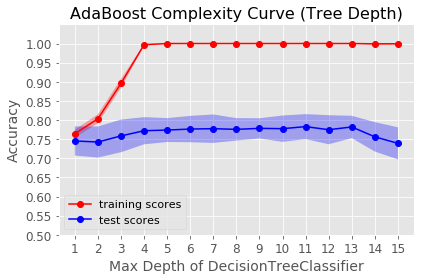

In [37]:
def plot_complexity_curve_bdt1():
    val_train_result = [np.array([])]
    val_train_std = np.array([])
    val_test_result = np.array([])
    val_test_std = np.array([])
    sizes = range(1, 16)
    for i in sizes:
        clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=i),learning_rate=1,algorithm="SAMME")
        results = cross_validate(clf, X_train, y_train, cv=10, return_train_score=True)

        val_train_result = np.append(val_train_result, results['train_score'].mean())
        val_test_result = np.append(val_test_result, results['test_score'].mean())
        val_train_std = np.append(val_train_std, results['train_score'].std())
        val_test_std = np.append(val_test_std, results['test_score'].std())                     
        
    lines1 = plt.plot(sizes,val_train_result , 'o-', color = 'r', label='training scores')
    lines2 = plt.plot(sizes,val_test_result , 'o-', color = 'b', label='test scores')

    plt.fill_between(sizes, val_train_result - val_train_std, val_train_result + val_train_std, edgecolor='none',
                     facecolor=lines1[0].get_color(), alpha=0.3)
    plt.fill_between(sizes, val_test_result - val_test_std, val_test_result + val_test_std, edgecolor='none',
                     facecolor=lines2[0].get_color(), alpha=0.3)
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xticks(sizes)
    plt.xlabel('Max Depth of DecisionTreeClassifier'); plt.ylabel('Accuracy')
    plt.title('AdaBoost Complexity Curve 1(Tree max_depth)', fontsize=16)    
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('AdaBoost Complexity Curve 1 (Tree max_depth)', tight_layout=True)
    
plot_complexity_curve_bdt1()

Saving figure AdaBoost Complexity Curve (n_estimators)


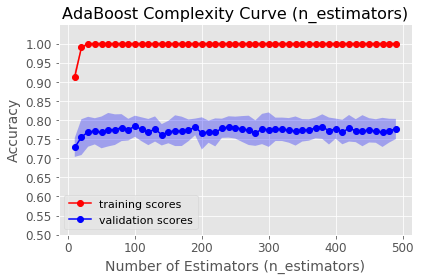

In [23]:
def plot_complexity_curve_bdt2():
    param_name="n_estimators"
    param_range=range(10, 500, 10)
    val_train, val_test = validation_curve(AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),
                                           learning_rate=1,algorithm="SAMME"),
                                           X_train, y_train, 
                                           param_name=param_name, param_range=param_range, cv=10)
    #print (val_train)
    plot_curve(param_range, val_train, label='training scores', color = 'r')
    plot_curve(param_range, val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('Number of Estimators (n_estimators)'); plt.ylabel('Accuracy')
    plt.title('AdaBoost Complexity Curve 2 (n_estimators)', fontsize=16)    
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('AdaBoost Complexity Curve 2 (n_estimators)', tight_layout=True)

plot_complexity_curve_bdt2()

Saving figure AdaBoost Learning Curve


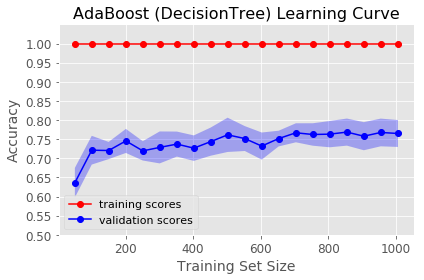

In [24]:
def plot_learning_curve_bdt():
    train_sizes = np.linspace(0.05, 1, 20) 
    # if the train size is too small, training sample may only contain one class
    N_train, val_train, val_test = learning_curve(AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),
                                                                     n_estimators=100,learning_rate=1,algorithm="SAMME"),
                                                  X_train, y_train, train_sizes=train_sizes, cv=10)
    plot_curve(N_train, val_train, label='training scores', color = 'r')
    plot_curve(N_train, val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('Training Set Size'); plt.ylabel('Accuracy')
    plt.title('AdaBoost Learning Curve', fontsize=16)    
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('AdaBoost Learning Curve', tight_layout=True)
    
plot_learning_curve_bdt()

In [25]:
bdt_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=5),
    n_estimators=100,
    learning_rate=1,
    algorithm="SAMME")
bdt_clf.fit(X_train, y_train)
test_score = bdt_clf.score(X_test, y_test)
print ('AdaBoost Model Prediction Accuracy on Test Data: {:.4f}'.format(test_score))

0.81874999999999998

# SVC

Saving figure SVC Complexity Curve (C)


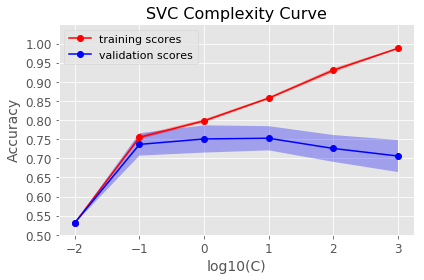

In [26]:
def plot_complexity_curve_svm1():
    param_name="C"
    param_range=[0.01, 0.1, 1, 10, 100, 1000]
    val_train, val_test = validation_curve(SVC(kernel= 'rbf'),
                                           X_train, y_train, 
                                           param_name=param_name, param_range=param_range, cv=10)
    plot_curve(np.log10(param_range), val_train, label='training scores', color = 'r')
    plot_curve(np.log10(param_range), val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('log10(C)'); plt.ylabel('Accuracy')
    plt.title('SVC Complexity Curve 1 (C)', fontsize=16)
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('SVC Complexity Curve 1 (C)', tight_layout=True)
    
plot_complexity_curve_svm1()

Saving figure SVC Complexity Curve 2 (gamma)


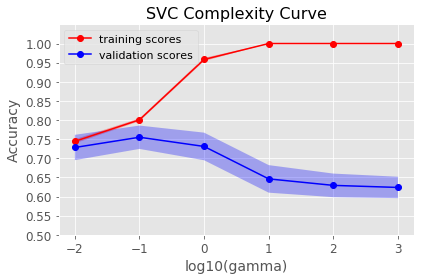

In [27]:
def plot_complexity_curve_svm2():
    #train_sizes = np.linspace(0.1, 0.95, 18)
    param_name="gamma"
    param_range=[0.01, 0.1, 1, 10, 100, 1000]
    val_train, val_test = validation_curve(SVC(kernel= 'rbf', C = 1),
                                           X_train, y_train, 
                                           param_name=param_name, param_range=param_range, cv=10)
    #print (val_train)
    plot_curve(np.log10(param_range), val_train, label='training scores', color = 'r')
    plot_curve(np.log10(param_range), val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('log10(gamma)'); plt.ylabel('Accuracy')
    plt.title('SVC Complexity Curve 2 (gamma)', fontsize=16)
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('SVC Complexity Curve 2 (gamma)', tight_layout=True)
    
plot_complexity_curve_svm2()

Saving figure SVC Learning Curve


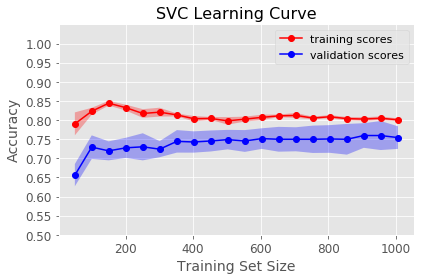

In [28]:
def plot_learning_curve_svm():
    train_sizes = np.linspace(0.05, 1, 20) 
    # if the train size is too small, training sample may only contain one class
    N_train, val_train, val_test = learning_curve(SVC(kernel= 'rbf', C = 1, gamma = 0.1),
                                                  X_train, y_train, train_sizes=train_sizes, cv=10)
    plot_curve(N_train, val_train, label='training scores', color = 'r')
    plot_curve(N_train, val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('Training Set Size'); plt.ylabel('Accuracy')
    plt.title('SVC Learning Curve', fontsize=16)
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('SVC Learning Curve', tight_layout=True)
    
plot_learning_curve_svm()

In [29]:
# svm_clf = SVC(kernel='linear', C=1)
#svm_clf = SVC(kernel='rbf', C=100, gamma='auto')
svm_clf = SVC(kernel='rbf', C=1, gamma=0.1)
svm_clf.fit(X_train, y_train)
test_score = svm_clf.score(X_test, y_test)
print ('SVM Model Prediction Accuracy on Test Data: {:.4f}'.format(test_score))

0.76041666666666663

In [30]:
# svm_clf = SVC(kernel='linear', C=1)
svm_clf = SVC(kernel='linear', C=1)
svm_clf.fit(X_train, y_train)
test_score = svm_clf.score(X_test, y_test)
print ('SVM Model Prediction Accuracy on Test Data: {:.4f}'.format(test_score))

0.74375000000000002

# KNN

Saving figure KNN Complexity Curve (n_neighbors)


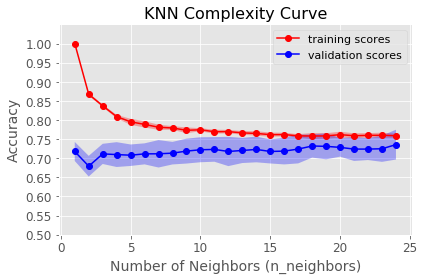

In [31]:
def plot_complexity_curve_knn():
    param_name="n_neighbors"
    param_range=range(1, 25)
    val_train, val_test = validation_curve(KNeighborsClassifier(),
                                           X_train, y_train, 
                                           param_name=param_name, param_range=param_range, cv=10)
    #print (val_train)
    plot_curve(param_range, val_train, label='training scores', color = 'r')
    plot_curve(param_range, val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('Number of Neighbors (n_neighbors)'); plt.ylabel('Accuracy')
    plt.title('KNN Complexity Curve (n_neighbors)', fontsize=16)
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('KNN Complexity Curve (n_neighbors)', tight_layout=True)
    
plot_complexity_curve_knn()

Saving figure KNN Learning Curve


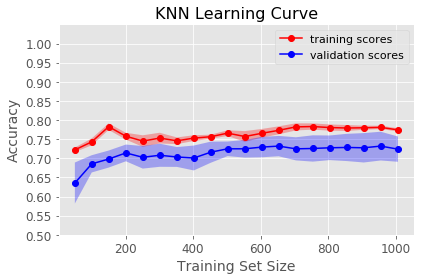

In [32]:
def plot_learning_curve_knn():
    train_sizes = np.linspace(0.05, 1, 20) 
    # if the train size is too small, training sample may only contain one class
    N_train, val_train, val_test = learning_curve(KNeighborsClassifier(n_neighbors=10),
                                                  X_train, y_train, train_sizes=train_sizes, cv=10)
    plot_curve(N_train, val_train, label='training scores', color = 'r')
    plot_curve(N_train, val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('Training Set Size'); plt.ylabel('Accuracy')
    plt.title('KNN Learning Curve', fontsize=16)
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('KNN Learning Curve', tight_layout=True)
    
plot_learning_curve_knn()

In [33]:
knn_clf = KNeighborsClassifier(n_neighbors=1)
knn_clf.fit(X_train, y_train)
test_score = knn_clf.score(X_test, y_test)
print ('KNN Model Prediction Accuracy on Test Data: {:.4f}'.format(test_score))

0.77500000000000002

In [34]:
knn_clf = KNeighborsClassifier(n_neighbors=19)
knn_clf.fit(X_train, y_train)
test_score = knn_clf.score(X_test, y_test)
print ('KNN Model Prediction Accuracy on Test Data: {:.4f}'.format(test_score))

0.73541666666666672